## Movie Recommendation Predict

Recommender systems play a vital role in today's technology-driven world by helping individuals make informed choices about the content they engage with daily. This is particularly true for movie recommendations, where intelligent algorithms can assist viewers in discovering great titles from a vast selection. Have you ever wondered how streaming platforms like Netflix, Amazon Prime, Showmax, and Disney seem to know what to recommend to you? In this challenge we will walk you through our movie recommender.

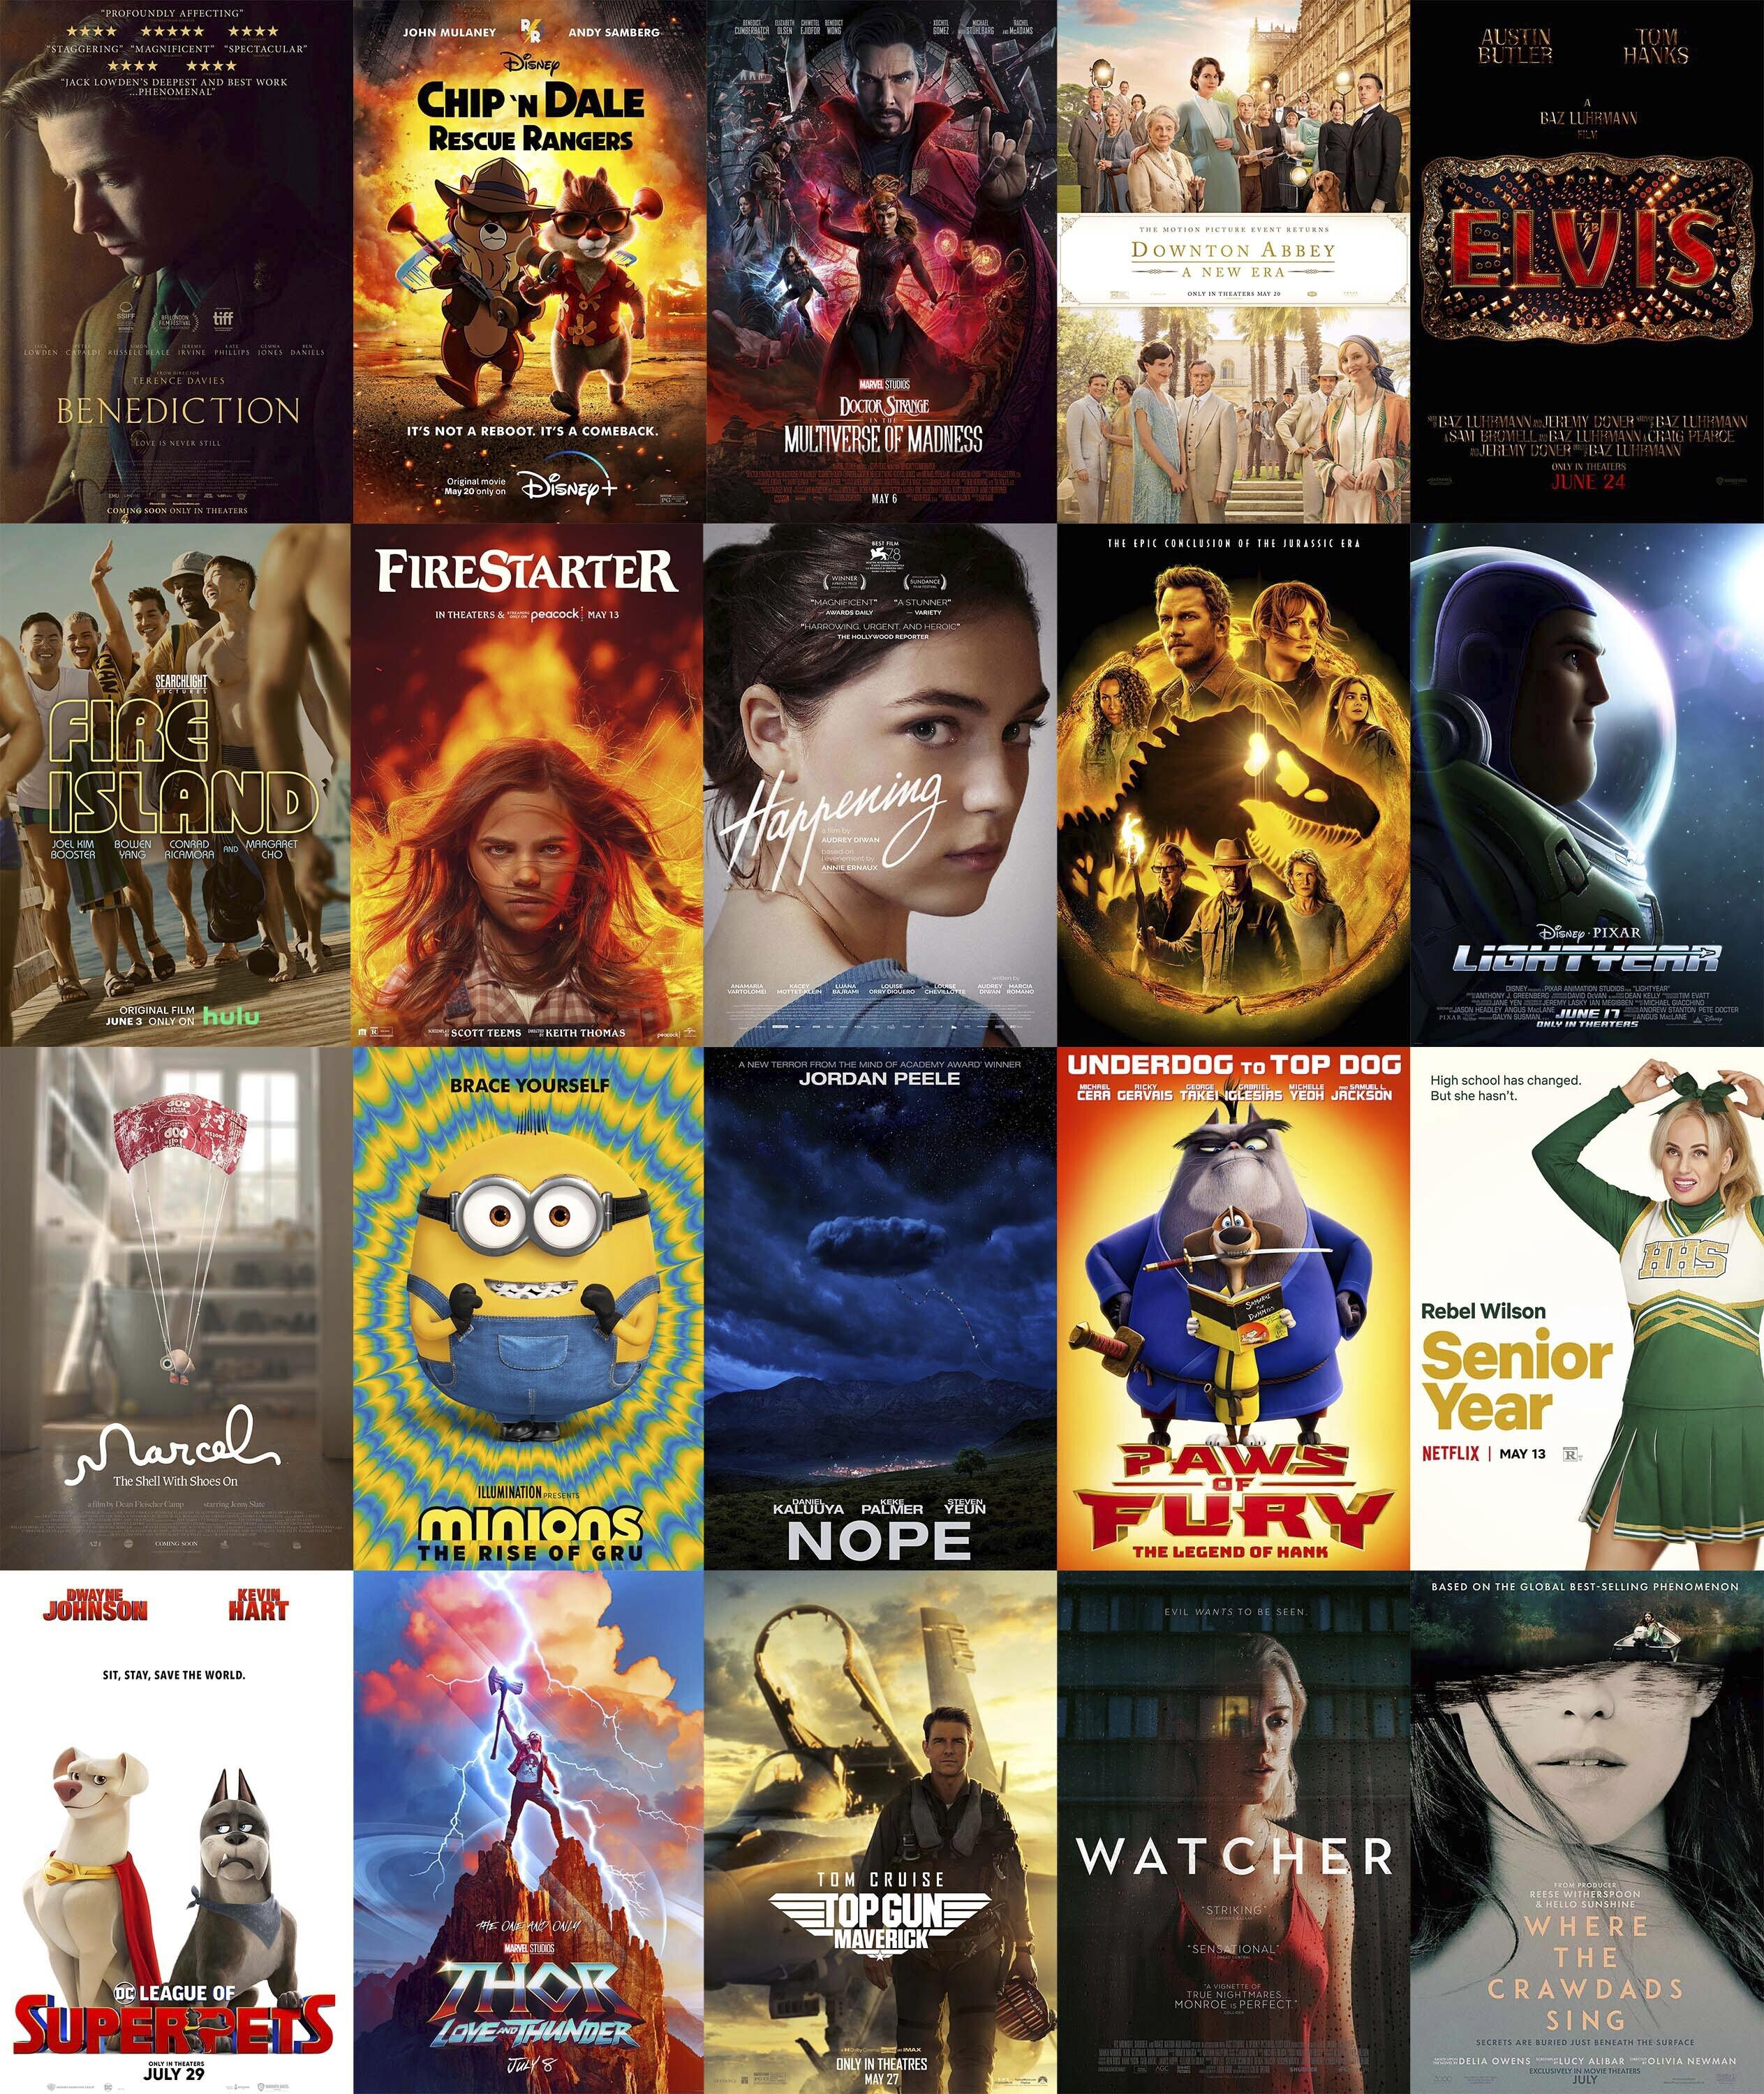

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading The Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>


   <a href=#six>6.1 Kaggle Submission CSV File</a>
   

<a href=#eight>7. Conclusion</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [1]:
#firstly to import important libraries
import pandas as pd
import numpy as np
#for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from plotly import graph_objects as go
#to display codes without warning
import warnings
warnings.filterwarnings('ignore')

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

There are a few dataframes that are to be imported, so simply importing the data for now and having the information within displayed a little down the line will help keep the notebook more aestheticaly pleasing.

In [2]:
genome_scores = pd.read_csv("genome_scores.csv")
genome_tags=pd.read_csv("genome_tags.csv")
imdb_data= pd.read_csv("imdb_data.csv")
links= pd.read_csv("links.csv")
movies= pd.read_csv("movies.csv")
tags= pd.read_csv("tags.csv")
df_test=pd.read_csv("test.csv")
df_train= pd.read_csv("train.csv")

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Having imported all of the data, it becomes clear that there is a lot of data to go through. This might prove dificult to provide an acurate analysis of the data. So to go through it with more ease, a basic EDA module was created to help show the basic information of each dataframe. this EDA function shows if the dataset has: missing values and also the position of the missing values, outliers and their position as well, check the data types, check value count, and lastly the correlation of the data.

In [3]:
def EDA(data):
    """Perform exploratory data analysis on a given dataset.
    Args:
      data (pandas.DataFrame): The dataset to analyze.
    """
    from IPython.display import display
    display(data.head())
    # Check for missing values
    if data.isnull().values.any():
        # Find the number of missing values for each column
        missing_counts = data.isnull().sum()
        # Select only the columns with missing values
        missing_columns = missing_counts[missing_counts > 0]
        print(f"Missing values found in columns: {missing_columns}")
    else:
        print("No missing values found")

    # Check for outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    if outliers.empty:
        print("No outliers found")
    else:
        print(f"Outliers found at positions: {outliers.index}")

    # Check data types
    data_types = data.dtypes
    print(f"Data types: {data_types}")

    # Check value counts for relevant columns
    relevant_values = ['yes', 'Yes', 'y', 'Y', 'no', 'No', 'n', 'N', 'Boy', 'Girl','boy','girl','g','b','G','B', 'Male', 'male', 'm', 'M', 'Female', 'female', 'f',
                       'F']
    for column in data.columns:
        if any(value in data[column].unique() for value in relevant_values):
            counts = data[column].value_counts()

    # Check correlations
    correlations = data.corr()
    display(correlations)

With EDA function above, now it is easier going through each dataframe and perfom simple data exploration. Below this step is completed swiftly

In [4]:
#firstly the genome score
EDA(genome_scores)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=15584448, step=1)
Data types: movieId        int64
tagId          int64
relevance    float64
dtype: object


,movieId,tagId,relevance
movieId,1.000000e+00,-1.390078e-13,0.015355
tagId,-1.390078e-13,1.000000e+00,0.017763
relevance,1.535521e-02,1.776320e-02,1.000000


In [5]:
#genome tags
EDA(genome_tags)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=1128, step=1)
Data types: tagId     int64
tag      object
dtype: object


,tagId
tagId,1.0


In [6]:
#for the imdb data
EDA(imdb_data)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


Missing values found in columns: title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=27278, step=1)
Data types: movieId            int64
title_cast        object
director          object
runtime          float64
budget            object
plot_keywords     object
dtype: object


,movieId,runtime
movieId,1.00000,-0.13273
runtime,-0.13273,1.00000


In [7]:
#the movies dataframe
EDA(movies)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=62423, step=1)
Data types: movieId     int64
title      object
genres     object
dtype: object


,movieId
movieId,1.0


In [8]:
#lastly the tags
EDA(tags)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Missing values found in columns: tag    16
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=1093360, step=1)
Data types: userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object


,userId,movieId,timestamp
userId,1.000000,-0.101326,-0.197582
movieId,-0.101326,1.000000,0.400216
timestamp,-0.197582,0.400216,1.000000


From the above information, it becomes clear that the data contains little missing values, with only missing values found the 'imdb_data' being only four and as well on 'tags' having one missing value. As for the outliers, the data seems have quite a few outliers. This could be due to the diversity of the data, how the data was entered or a myriad of other reasons. It might prove more fruitful to display the data numerical data and see how much of the data is outlier prone.
The data types seem to show that the prominent datatypes are intergers and objects with only 2 columns being float datatypes.

For the visuals, 

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

The 'imdb_data' has been deemed an essential dataframe so all merges will be conducted on it. first merge would be to bring the 'movies' dataframe into the 'imdb_data'. This is because the genre and title columns are going to be needed later on for the recomender. Then proceed to merge the genome scores as the tagId and relevance columns are going to become useful. and lastly bringing in the 'tags' dataframe because the columns 'userId', 'tag' and 'timestamp' will be vital in the process of recomendation.

In [9]:
first_merge= imdb_data.merge(movies, how='left')
second_merge=first_merge.merge(genome_scores, how='left')
second_merge

,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres,tagId,relevance
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,0.02875
1,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,0.02375
2,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,0.06250
3,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,0.07575
4,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,0.14075
...,...,...,...,...,...,...,...,...,...,...
13810483,131254,Franz Dinda|Florian Lukas|Axel Stein|Kailas Ma...,Carsten Funke,85.0,NaN,man wrapped in a towel|man wears a thong|male ...,Kein Bund für's Leben (2007),Comedy,NaN,NaN
13810484,131256,Rick Kavanian|Axel Stein|Eva Habermann|Christo...,Matthias Dinter,83.0,"DEM5,800,000",ski|ski resort|ampersand in title|drink in title,"Feuer, Eis & Dosenbier (2002)",Comedy,NaN,NaN
13810485,131258,Nam-gil Kim|Ye-jin Son|Hae-Jin Yoo|Kyeong-yeon...,Seong-il Cheon,130.0,NaN,pirate|sword fight|korea|bandit,The Pirates (2014),Adventure,NaN,NaN
13810486,131260,Martti Suosalo|Ilkka Koivula|Vexi Salmi|Riitta...,Timo Koivusalo,102.0,NaN,friend|friendship|television show|restaurant,Rentun Ruusu (2001),(no genres listed),NaN,NaN
